# **BitePulse AI - Dataset acquisition and audit**



## **Introduction**

Here in this notebook, we'll download, verify, and organize the EatSense dataset for BitePulse AI:

* Mount Google Drive, confirm free space, and set a single data root.
* Download EatSense data using a fast, resumable method.
* Verify archives for integrity before extraction.
* Extract archives into organized folders, including any zip files packed inside other zips.
* Generate a quick inventory of folders, file counts, and sizes.
* Sanity check the setup.

**Folders Plan:**

* `.../eatsense/zips` holds the original downloads.
* `.../eatsense/rgb` holds RGB videos.
* `.../eatsense/depth` holds depth maps.
* `.../eatsense/poses_true` holds true face pose csv files.
* `.../eatsense/poses_fake` holds fake face pose csv files.
* `.../eatsense/test holds` the official test set.
* `.../eatsense/all_misc` holds documents and readme files

## **Dataset**

BitePulse AI is trained on [EatSense](https://groups.inf.ed.ac.uk/vision/DATASETS/EATSENSE/), a research dataset of real people eating real meals, with every frame labeled for actions like eating, chewing, drinking, or resting. Faces are anonymized. This lets us train deep learning models to detect bites and pacing patterns without recording new users.

In the real product, BitePulse AI can run privately on device for consumers, or through a secure backend for wellness partners. For this capstone, we only use the public [EatSense](https://groups.inf.ed.ac.uk/vision/DATASETS/EATSENSE/) dataset, and we do not collect or store new personal video.

## **Imports and basic setup**

In [ ]:
# Due to EatSense Large files let's download Faster downloader aria2:
!apt-get -y install -qq aria2

Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 125079 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not

In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob, os, shlex, subprocess, collections, re
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


## **Setups the Google drives paths**

In [ ]:
# Paths:
ROOT = Path("/content/drive/MyDrive/eatsense")
ZIPS = ROOT / "zips"
OUT  = ROOT

RGB_DIR        = OUT / "rgb"
DEPTH_DIR      = OUT / "depth"
POSES_TRUE_DIR = OUT / "poses_true"
POSES_FAKE_DIR = OUT / "poses_fake"
TEST_DIR       = OUT / "test"
MISC_DIR       = OUT / "all_misc"

# Create folders if missing:
for p in [ZIPS, RGB_DIR, DEPTH_DIR, POSES_TRUE_DIR, POSES_FAKE_DIR, TEST_DIR, MISC_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Make paths available to bash cells:
os.environ["ROOT"] = str(ROOT)
os.environ["ZIPS"] = str(ZIPS)
os.environ["OUT"]  = str(OUT)

# Quick environment summary:
print("Root:", ROOT)
print("Zips:", ZIPS)
print("Output:", OUT)

Root: /content/drive/MyDrive/eatsense
Zips: /content/drive/MyDrive/eatsense/zips
Output: /content/drive/MyDrive/eatsense


In [ ]:
# Free space check:
!df -h /content/drive | tail -n 1

drive           100G  3.9G   97G   4% /content/drive


## **Download the dataset- EatSense**

Here let's download the EatSense archives into the zips folder on Drive. I will use aria2 for resumable downloads. I will start with the All in one zip. Later will be adding the individual archives.

In [ ]:
# Alright now let's use All in one zip URL from the EatSense page:
ALL_URL = "https://datashare.ed.ac.uk/download/DS_10283_8759.zip"

os.environ["ALL_URL"] = ALL_URL

# Confirm:
print("ALL_URL:", os.environ["ALL_URL"])
print("ZIPS:", os.environ["ZIPS"])



ALL_URL: https://datashare.ed.ac.uk/download/DS_10283_8759.zip
ZIPS: /content/drive/MyDrive/eatsense/zips


In [ ]:
%%bash
# Download to the zips folder:
aria2c -c -x 16 -s 16 -d "$ZIPS" -o "eatsense_all_in_one.zip" "$ALL_URL"



10/31 02:20:26 [NOTICE] Downloading 1 item(s)

10/31 02:20:26 [NOTICE] Allocating disk space. Use --file-allocation=none to disable it. See --file-allocation option in man page for more details.
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 307MiB/27GiB(1%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 0.9GiB/27GiB(3%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 1.4GiB/27GiB(5%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 2.1GiB/27GiB(7%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 2.3GiB/27GiB(8%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 2.5GiB/27GiB(9%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 2.7GiB/27GiB(9%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 3.1GiB/27GiB(11%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 3.4GiB/27GiB(12%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 4.0GiB/27GiB(14%)]
[#c4955a 0B/27GiB(0%) CN:1 DL:0B] [FileAlloc:#c4955a 4.6GiB/27GiB(17%)]
[#c4955a 0B/27GiB(0

In [ ]:
%%bash
# Inspect ifthe file is present and it's size:
ls -lh "$ZIPS/eatsense_all_in_one.zip"

-rw------- 1 root root 28G Oct 31 02:28 /content/drive/MyDrive/eatsense/zips/eatsense_all_in_one.zip


## **Extract all archives**

Here let's handle both the main bundle and any inner zip files

In [ ]:
%%bash
set -e

ROOT="/content/drive/MyDrive/eatsense"
ZIPS="$ROOT/zips"
OUT="$ROOT"
TMP="/content/eatsense_tmp"

mkdir -p "$ZIPS" "$OUT"/{rgb,depth,poses_true,poses_fake,test,all_misc} "$TMP"
shopt -s nullglob nocaseglob

# Unpack any master bundle that starts with DS or ds:
for z in "$ZIPS"/DS_*.zip "$ZIPS"/ds_*.zip; do
  [ -e "$z" ] || continue
  echo "Unpacking master bundle:" "$(basename "$z")"
  rm -rf "$TMP"/* 2>/dev/null || true
  unzip -n -q -DD "$z" -d "$TMP"

  # Move every inner zip found anywhere under TMP into ZIPS:
  while IFS= read -r inner; do
    echo "Staging inner zip:" "$(basename "$inner")"
    mv -n "$inner" "$ZIPS"/
  done < <(find "$TMP" -type f -iname '*.zip')

  # Copy non zip docs into all_misc:
  rsync -a --ignore-existing --exclude='*.zip' "$TMP"/ "$OUT/all_misc"/
done

# Extract all staged archives to organized folders:
for z in "$ZIPS"/*.zip; do
  base="$(basename "$z" | tr '[:upper:]' '[:lower:]')"
  if   [[ "$base" == *"deepfaked"* || "$base" == *"rgb"* ]]; then out="$OUT/rgb"
  elif [[ "$base" == *"depth"* ]];                          then out="$OUT/depth"
  elif [[ "$base" == *"true"*  && "$base" == *"2d3d"* ]];   then out="$OUT/poses_true"
  elif [[ "$base" == *"faked"* && "$base" == *"2d3d"* ]];   then out="$OUT/poses_fake"
  elif [[ "$base" == *"test"* ]];                           then out="$OUT/test"
  else  out="$OUT/all_misc"
  fi
  echo "Extracting:" "$(basename "$z")" "->" "$out"
  unzip -n -q -DD "$z" -d "$out"
done

echo "Extraction complete."


Extracting: eatsense_all_in_one.zip -> /content/drive/MyDrive/eatsense/all_misc
Extraction complete.


In [ ]:
%%bash
OUT="/content/drive/MyDrive/eatsense"

echo "Top-level sizes:"
du -h --max-depth=1 "$OUT" | sort -h

echo
echo "Counts by folder:"
for d in "$OUT"/*/; do
  dcount=$(find "$d" -type d | wc -l)
  fcount=$(find "$d" -type f | wc -l)
  printf "%-30s dirs:%6d  files:%7d\n" "$(basename "$d")" "$dcount" "$fcount"
done | sort


Top-level sizes:
4.0K	/content/drive/MyDrive/eatsense/depth
4.0K	/content/drive/MyDrive/eatsense/poses_fake
4.0K	/content/drive/MyDrive/eatsense/poses_true
4.0K	/content/drive/MyDrive/eatsense/rgb
4.0K	/content/drive/MyDrive/eatsense/test
28G	/content/drive/MyDrive/eatsense/all_misc
28G	/content/drive/MyDrive/eatsense/zips
55G	/content/drive/MyDrive/eatsense

Counts by folder:
all_misc                       dirs:     1  files:     38
depth                          dirs:     1  files:      0
poses_fake                     dirs:     1  files:      0
poses_true                     dirs:     1  files:      0
rgb                            dirs:     1  files:      0
test                           dirs:     1  files:      0
zips                           dirs:     1  files:      1


Now let's check space and current layout:

In [ ]:
%%bash
OUT="/content/drive/MyDrive/eatsense"
echo "Top level sizes:"
du -h --max-depth=1 "$OUT" | sort -h
echo
echo "Zip files:"
ls -lh "$OUT"/zips/*.zip 2>/dev/null || echo "No zips found"

Top level sizes:
4.0K	/content/drive/MyDrive/eatsense/depth
4.0K	/content/drive/MyDrive/eatsense/poses_fake
4.0K	/content/drive/MyDrive/eatsense/poses_true
4.0K	/content/drive/MyDrive/eatsense/rgb
4.0K	/content/drive/MyDrive/eatsense/test
28G	/content/drive/MyDrive/eatsense/all_misc
28G	/content/drive/MyDrive/eatsense/zips
55G	/content/drive/MyDrive/eatsense

Zip files:
-rw------- 1 root root 28G Oct 31 02:28 /content/drive/MyDrive/eatsense/zips/eatsense_all_in_one.zip


Here let's move any inner zips that landed in all_misc:

In [ ]:
%%bash
set -e
OUT="/content/drive/MyDrive/eatsense"
ZIPS="$OUT/zips"
MISC="$OUT/all_misc"

mkdir -p "$ZIPS"
shopt -s nullglob nocaseglob
# move any zip files found under all_misc into zips:
find "$MISC" -type f -iname '*.zip' -print -exec mv -n {} "$ZIPS"/ \;
echo "Inner zips staged to zips"
ls -lh "$ZIPS" || true


/content/drive/MyDrive/eatsense/all_misc/all_depth.zip
/content/drive/MyDrive/eatsense/all_misc/deepfaked.zip
/content/drive/MyDrive/eatsense/all_misc/Faked_2D3D.zip
/content/drive/MyDrive/eatsense/all_misc/testset.zip
/content/drive/MyDrive/eatsense/all_misc/True2D3D.zip
Inner zips staged to zips
total 54G
-rw------- 1 root root  15G Oct 31 02:48 all_depth.zip
-rw------- 1 root root  11G Oct 31 02:51 deepfaked.zip
-rw------- 1 root root  28G Oct 31 02:28 eatsense_all_in_one.zip
-rw------- 1 root root 141M Oct 31 02:51 Faked_2D3D.zip
-rw------- 1 root root 410M Oct 31 02:51 testset.zip
-rw------- 1 root root 126M Oct 31 02:51 True2D3D.zip


In [ ]:
%%bash
set -e
OUT="/content/drive/MyDrive/eatsense"
ZIPS="$OUT/zips"

# extract true poses only:
unzip -n -q -DD "$ZIPS/True2D3D.zip" -d "$OUT/poses_true"
rm -f "$ZIPS/True2D3D.zip"

# extract fake poses only:
unzip -n -q -DD "$ZIPS/Faked_2D3D.zip" -d "$OUT/poses_fake"
rm -f "$ZIPS/Faked_2D3D.zip"

# extract test set:
unzip -n -q -DD "$ZIPS/testset.zip" -d "$OUT/test"
rm -f "$ZIPS/testset.zip"

# extract rgb videos:
unzip -n -q -DD "$ZIPS/deepfaked.zip" -d "$OUT/rgb"
rm -f "$ZIPS/deepfaked.zip"

# extract depth maps:
unzip -n -q -DD "$ZIPS/all_depth.zip" -d "$OUT/depth"
rm -f "$ZIPS/all_depth.zip"


## **Sanity Checks**

In [ ]:
# Set paths once:
ROOT = Path("/content/drive/MyDrive/eatsense")
RGB_DIR        = ROOT / "rgb"
DEPTH_DIR      = ROOT / "depth" / "all_depth"
POSES_TRUE_DIR = ROOT / "poses_true"
POSES_FAKE_DIR = ROOT / "poses_fake"
TEST_DIR       = ROOT / "test"
MISC_DIR       = ROOT / "all_misc"
ZIPS_DIR       = ROOT / "zips"

paths = {
    "rgb": RGB_DIR,
    "depth": DEPTH_DIR,
    "poses_true": POSES_TRUE_DIR,
    "poses_fake": POSES_FAKE_DIR,
    "test": TEST_DIR,
    "all_misc": MISC_DIR,
    "zips": ZIPS_DIR,
}

for name, p in paths.items():
    print(name, "exists:", p.exists(), "path:", p)


rgb exists: True path: /content/drive/MyDrive/eatsense/rgb
depth exists: True path: /content/drive/MyDrive/eatsense/depth/all_depth
poses_true exists: True path: /content/drive/MyDrive/eatsense/poses_true
poses_fake exists: True path: /content/drive/MyDrive/eatsense/poses_fake
test exists: True path: /content/drive/MyDrive/eatsense/test
all_misc exists: True path: /content/drive/MyDrive/eatsense/all_misc
zips exists: True path: /content/drive/MyDrive/eatsense/zips


In [ ]:
%%bash
OUT="/content/drive/MyDrive/eatsense"

echo "Top-level sizes:"
du -h --max-depth=1 "$OUT" | sort -h

echo
echo "Counts by folder:"
for d in "$OUT"/*/; do
  dcount=$(find "$d" -type d | wc -l)
  fcount=$(find "$d" -type f | wc -l)
  printf "%-30s dirs:%6d  files:%7d\n" "$(basename "$d")" "$dcount" "$fcount"
done | sort


Top-level sizes:
429M	/content/drive/MyDrive/eatsense/test
580M	/content/drive/MyDrive/eatsense/poses_true
637M	/content/drive/MyDrive/eatsense/poses_fake
1.3G	/content/drive/MyDrive/eatsense/all_misc
11G	/content/drive/MyDrive/eatsense/rgb
15G	/content/drive/MyDrive/eatsense/depth
28G	/content/drive/MyDrive/eatsense/zips
56G	/content/drive/MyDrive/eatsense

Counts by folder:
all_misc                       dirs:     1  files:     33
depth                          dirs:     2  files:    133
poses_fake                     dirs:     3  files:    270
poses_true                     dirs:     3  files:    270
rgb                            dirs:     2  files:    135
test                           dirs:     8  files:     36
zips                           dirs:     1  files:      1


In [ ]:
# Count common file types in each folder:

def count_types(root):
    files = glob.glob(os.path.join(str(root), "**", "*.*"), recursive=True)
    exts = collections.Counter([os.path.splitext(p)[1].lower() for p in files])
    return len(files), exts

for name, p in paths.items():
    total, exts = count_types(p)
    print(name, "total files:", total, "by extension:", dict(exts))


rgb total files: 135 by extension: {'.mp4': 135}
depth total files: 133 by extension: {'.mp4': 133}
poses_true total files: 270 by extension: {'.csv': 270}
poses_fake total files: 270 by extension: {'.csv': 270}
test total files: 36 by extension: {'.mp4': 12, '.csv': 24}
all_misc total files: 33 by extension: {'.mp4': 10, '.csv': 20, '.pdf': 2, '.txt': 1}
zips total files: 1 by extension: {'.zip': 1}


In [ ]:
assert RGB_DIR.exists(), "rgb folder is missing"
assert DEPTH_DIR.exists(), "depth folder is missing"
assert POSES_TRUE_DIR.exists(), "poses_true folder is missing"
assert POSES_FAKE_DIR.exists(), "poses_fake folder is missing"
assert TEST_DIR.exists(), "test folder is missing"

rgb_mp4  = glob.glob(os.path.join(str(RGB_DIR), "**", "*.mp4"), recursive=True)
depth_mp4= glob.glob(os.path.join(str(DEPTH_DIR), "**", "*.mp4"), recursive=True)
true_csv = glob.glob(os.path.join(str(POSES_TRUE_DIR), "**", "*.csv"), recursive=True)
fake_csv = glob.glob(os.path.join(str(POSES_FAKE_DIR), "**", "*.csv"), recursive=True)
test_any = glob.glob(os.path.join(str(TEST_DIR), "**", "*.*"), recursive=True)

print("rgb videos:", len(rgb_mp4))
print("depth videos:", len(depth_mp4))
print("true pose csv:", len(true_csv))
print("fake pose csv:", len(fake_csv))
print("test files:", len(test_any))

assert len(rgb_mp4)  > 0, "no rgb videos found"
assert len(depth_mp4)> 0, "no depth videos found"
assert len(true_csv) > 0, "no true pose csv found"
assert len(fake_csv) > 0, "no fake pose csv found"
assert len(test_any) > 0, "no test files found"


rgb videos: 135
depth videos: 133
true pose csv: 270
fake pose csv: 270
test files: 36


In [ ]:
def sample(paths, k=3):
    return paths[:k] if len(paths) >= k else paths

print("rgb samples:", sample(sorted(rgb_mp4)))
print("depth samples:", sample(sorted(depth_mp4)))
print("true csv samples:", sample(sorted(true_csv)))
print("fake csv samples:", sample(sorted(fake_csv)))


rgb samples: ['/content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4', '/content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4', '/content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_150552_anonymized.mp4']
depth samples: ['/content/drive/MyDrive/eatsense/depth/all_depth/20210518_230219_depth.mp4', '/content/drive/MyDrive/eatsense/depth/all_depth/20210523_202300_depth.mp4', '/content/drive/MyDrive/eatsense/depth/all_depth/20210529_150552_depth.mp4']
true csv samples: ['/content/drive/MyDrive/eatsense/poses_true/True2D/20210518_230219.mp4_preds_HigherHRNet.csv', '/content/drive/MyDrive/eatsense/poses_true/True2D/20210523_202300.mp4_preds_HigherHRNet.csv', '/content/drive/MyDrive/eatsense/poses_true/True2D/20210529_150552.mp4_preds_HigherHRNet.csv']
fake csv samples: ['/content/drive/MyDrive/eatsense/poses_fake/Faked2D/20210518_230219_preds_HigherHRNet.csv', '/content/drive/MyDrive/eatsense/poses_fake/Faked2D/20210523_202300_preds_HigherHRNe

In [ ]:
rgb_stems = [os.path.splitext(os.path.basename(p))[0] for p in rgb_mp4]
true_stems = [os.path.basename(p) for p in true_csv]
fake_stems = [os.path.basename(p) for p in fake_csv]

hits_true = sum(any(s in t for t in true_stems) for s in rgb_stems)
hits_fake = sum(any(s in t for t in fake_stems) for s in rgb_stems)

print("rgb count:", len(rgb_stems))
print("rgb that match some true csv:", hits_true)
print("rgb that match some fake csv:", hits_fake)


rgb count: 135
rgb that match some true csv: 0
rgb that match some fake csv: 0


In [ ]:
%%bash
ROOT="/content/drive/MyDrive/eatsense"
echo "Zip files outside zips:"
find "$ROOT" -type f -iname '*.zip' ! -path "$ROOT/zips/*" -print || true

echo
echo "Nested zips under data folders:"
find "$ROOT"/{rgb,depth,poses_true,poses_fake,test} -type f -iname '*.zip' -print || true


Zip files outside zips:

Nested zips under data folders:


In [ ]:
ROOT = "/content/drive/MyDrive/eatsense"
RGB_DIR = f"{ROOT}/rgb"
POSES_TRUE_DIR = f"{ROOT}/poses_true"
POSES_FAKE_DIR = f"{ROOT}/poses_fake"

pat = re.compile(r"(\d{8}_\d{6})")

def key_from_path(p):
    n = os.path.basename(p).lower()
    m = pat.search(n)
    return m.group(1) if m else None

rgb = sorted(glob.glob(os.path.join(RGB_DIR, "**", "*.mp4"), recursive=True))
true_csv = sorted(glob.glob(os.path.join(POSES_TRUE_DIR, "**", "*.csv"), recursive=True))
fake_csv = sorted(glob.glob(os.path.join(POSES_FAKE_DIR, "**", "*.csv"), recursive=True))

rgb_keys  = {key_from_path(p): p for p in rgb if key_from_path(p)}
true_keys = {key_from_path(p): p for p in true_csv if key_from_path(p)}
fake_keys = {key_from_path(p): p for p in fake_csv if key_from_path(p)}

print("rgb keys:", len(rgb_keys))
print("true pose keys:", len(true_keys))
print("fake pose keys:", len(fake_keys))

overlap_true = sorted(set(rgb_keys) & set(true_keys))
overlap_fake = sorted(set(rgb_keys) & set(fake_keys))

print("rgb match with true pose by timestamp:", len(overlap_true))
print("rgb match with fake pose by timestamp:", len(overlap_fake))


rgb keys: 135
true pose keys: 135
fake pose keys: 135
rgb match with true pose by timestamp: 135
rgb match with fake pose by timestamp: 135


In [ ]:
def sample_pairs(keys, left_map, right_map, k=5):
    out = []
    for i, kk in enumerate(keys[:k]):
        out.append((kk, left_map[kk], right_map[kk]))
    return out

print("example matches with true:")
for kk, rv, tv in sample_pairs(overlap_true, rgb_keys, true_keys):
    print(kk)
    print("  rgb :", rv)
    print("  true:", tv)

print("\nexample matches with fake:")
for kk, rv, fv in sample_pairs(overlap_fake, rgb_keys, fake_keys):
    print(kk)
    print("  rgb :", rv)
    print("  fake:", fv)


example matches with true:
20210518_230219
  rgb : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4
  true: /content/drive/MyDrive/eatsense/poses_true/True3D/20210518_230219.csv
20210523_202300
  rgb : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4
  true: /content/drive/MyDrive/eatsense/poses_true/True3D/20210523_202300.csv
20210529_150552
  rgb : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_150552_anonymized.mp4
  true: /content/drive/MyDrive/eatsense/poses_true/True3D/20210529_150552.csv
20210529_153708
  rgb : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_153708_anonymized.mp4
  true: /content/drive/MyDrive/eatsense/poses_true/True3D/20210529_153708.csv
20210530_153343
  rgb : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210530_153343_anonymized.mp4
  true: /content/drive/MyDrive/eatsense/poses_true/True3D/20210530_153343.csv

example matches with fake:
20210518_230219
  rgb : /content/drive/MyDrive/eat

In [ ]:
# What did not match:
missing_true = sorted(set(rgb_keys) - set(true_keys))
missing_fake = sorted(set(rgb_keys) - set(fake_keys))
print("rgb without true poses:", len(missing_true))
print("rgb without fake poses:", len(missing_fake))

# peek a few to understand naming:
for kk in missing_true[:5]:
    print("no true for:", kk, "rgb path:", rgb_keys[kk])


rgb without true poses: 0
rgb without fake poses: 0


## **Build a pairing manifest**

Here's let's create one table that pairs each sample across all folders using a single timestamp key `yyyyMMMdd_HHmmss`. This manifest becomes the source of truth for loading aligned data.

**This table will help us:**

* Keeps rgb, depth, and pose files in sync.
* Makes data loading simple; I can iterate rows and know I have a complete set.
* Avoids silent errors: if any file is missing the row will not be created.
* Speeds up experiments: I can split, shuffle, and filter with one dataframe.
* Train or evaluate by iterating rows; each row is one synchronized sample.
* Build train or validation splits by sampling keys; store the split ids.

**Table Contents:**

* key;: timestamp string used to join files.
* rgb: full path to the rgb video.
* depth: full path to the depth video.
* poses underscore true: full path to the true pose csv.
* poses underscore fake: full path to the fake pose csv.




In [ ]:
# Alright now let's build a manifest keyed by timestamp:

ROOT = "/content/drive/MyDrive/eatsense"
RGB_DIR   = f"{ROOT}/rgb"
DEPTH_DIR = f"{ROOT}/depth/all_depth"
TRUE_DIR  = f"{ROOT}/poses_true"
FAKE_DIR  = f"{ROOT}/poses_fake"

pat = re.compile(r"(\d{8}_\d{6})")

def key_from_path(p):
    m = pat.search(os.path.basename(p).lower())
    return m.group(1) if m else None

rgb   = glob.glob(os.path.join(RGB_DIR,   "**", "*.mp4"), recursive=True)
depth = glob.glob(os.path.join(DEPTH_DIR, "**", "*.mp4"), recursive=True)
true_ = glob.glob(os.path.join(TRUE_DIR,  "**", "*.csv"), recursive=True)
fake_ = glob.glob(os.path.join(FAKE_DIR,  "**", "*.csv"), recursive=True)

rgb_map   = {key_from_path(p): p for p in rgb   if key_from_path(p)}
depth_map = {key_from_path(p): p for p in depth if key_from_path(p)}
true_map  = {key_from_path(p): p for p in true_ if key_from_path(p)}
fake_map  = {key_from_path(p): p for p in fake_ if key_from_path(p)}

keys = sorted(set(rgb_map) & set(depth_map) & set(true_map) & set(fake_map))
print("paired keys count:", len(keys))

rows = []
for k in keys:
    rows.append(dict(
        key=k,
        rgb=rgb_map[k],
        depth=depth_map[k],
        poses_true=true_map[k],
        poses_fake=fake_map[k],
    ))

manifest = pd.DataFrame(rows).sort_values("key").reset_index(drop=True)
print("manifest rows:", len(manifest))
manifest.head(10)


paired keys count: 133
manifest rows: 133


,key,rgb,depth,poses_true,poses_fake
0,20210518_230219,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
1,20210523_202300,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
2,20210529_150552,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
3,20210529_153708,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
4,20210530_153343,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
5,20210531_150448,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
6,20210603_130948,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
7,20210605_155355,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
8,20210606_154234,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...
9,20210607_152559,/content/drive/MyDrive/eatsense/rgb/deepfaked/...,/content/drive/MyDrive/eatsense/depth/all_dept...,/content/drive/MyDrive/eatsense/poses_true/Tru...,/content/drive/MyDrive/eatsense/poses_fake/Fak...


In [ ]:
# Now let's save the manifest:
out_csv = f"{ROOT}/manifest_eatsense.csv"
manifest.to_csv(out_csv, index=False)
print("saved:", out_csv)


saved: /content/drive/MyDrive/eatsense/manifest_eatsense.csv


In [ ]:
# Confirm that every file exists on disk:
missing = []
for col in ["rgb","depth","poses_true","poses_fake"]:
    bad = manifest[~manifest[col].map(os.path.exists)]
    if len(bad):
        missing.append((col, len(bad)))
print("missing summary:", missing if missing else "none")

# Show a few joined examples:
for i in range(3):
    r = manifest.iloc[i]
    print(i, r.key)
    print("  rgb   :", r.rgb)
    print("  depth :", r.depth)
    print("  true  :", r.poses_true)
    print("  fake  :", r.poses_fake)


missing summary: none
0 20210518_230219
  rgb   : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210518_230219_anonymized.mp4
  depth : /content/drive/MyDrive/eatsense/depth/all_depth/20210518_230219_depth.mp4
  true  : /content/drive/MyDrive/eatsense/poses_true/True3D/20210518_230219.csv
  fake  : /content/drive/MyDrive/eatsense/poses_fake/Faked3D/20210518_230219.csv
1 20210523_202300
  rgb   : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210523_202300_anonymized.mp4
  depth : /content/drive/MyDrive/eatsense/depth/all_depth/20210523_202300_depth.mp4
  true  : /content/drive/MyDrive/eatsense/poses_true/True3D/20210523_202300.csv
  fake  : /content/drive/MyDrive/eatsense/poses_fake/Faked3D/20210523_202300.csv
2 20210529_150552
  rgb   : /content/drive/MyDrive/eatsense/rgb/deepfaked/20210529_150552_anonymized.mp4
  depth : /content/drive/MyDrive/eatsense/depth/all_depth/20210529_150552_depth.mp4
  true  : /content/drive/MyDrive/eatsense/poses_true/True3D/20210529_150552.csv
  fake  :

key: 20221013_132443
rgb frame shape: (480, 640, 3)
depth frame shape: (480, 640, 3)


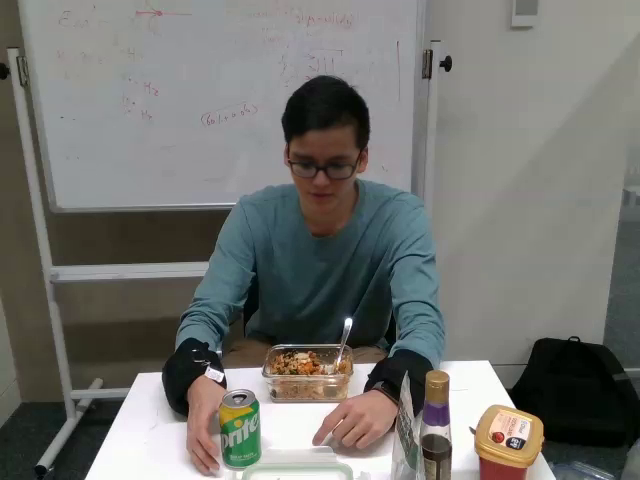

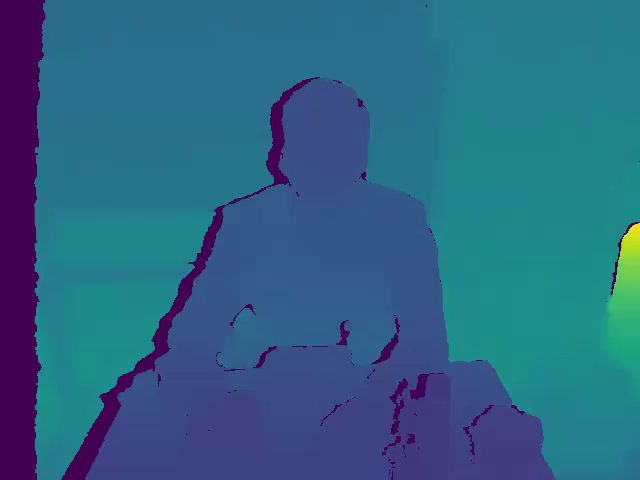

,Unnamed: 0,Project,Action,Imgs,head_x,head_y,head_z,Mid-Shoulder_x,Mid-Shoulder_y,Mid-Shoulder_z,...,Right-Wrist_z,Left-shoulder_x,Left-shoulder_y,Left-shoulder_z,Left-Elbow_x,Left-Elbow_y,Left-Elbow_z,Left-Wrist_x,Left-Wrist_y,Left-Wrist_z
0,0,20221013_132443,other,0,0.018564,0.133906,1.2300,0.005229,0.070231,1.389,...,1.1390,-0.160925,0.073420,1.407,-0.198137,-0.156175,1.307,-0.106796,-0.252626,1.070
1,1,20221013_132443,other,1,0.022582,0.136119,1.2320,0.007455,0.072272,1.385,...,1.1500,-0.161154,0.075807,1.409,-0.196772,-0.154647,1.312,-0.107717,-0.249017,1.062
2,2,20221013_132443,other,2,0.026677,0.136671,1.2370,0.007487,0.072585,1.391,...,1.1450,-0.159099,0.075914,1.411,-0.194945,-0.148499,1.314,-0.105829,-0.242474,1.027
3,3,20221013_132443,other,3,0.032762,0.139011,1.2345,0.009738,0.074838,1.390,...,1.1420,-0.157038,0.080599,1.410,-0.190692,-0.144242,1.313,-0.108642,-0.245071,1.050
4,4,20221013_132443,other,4,0.038845,0.143258,1.2385,0.012033,0.077368,1.391,...,1.1425,-0.154313,0.082652,1.410,-0.187148,-0.140519,1.314,-0.108851,-0.245543,1.039


,Unnamed: 0,Project,Action,Imgs,head_x,head_y,head_z,Mid-Shoulder_x,Mid-Shoulder_y,Mid-Shoulder_z,...,Right-Wrist_z,Left-shoulder_x,Left-shoulder_y,Left-shoulder_z,Left-Elbow_x,Left-Elbow_y,Left-Elbow_z,Left-Wrist_x,Left-Wrist_y,Left-Wrist_z
0,0,20221013_132443,other,0,0.018564,0.133906,1.2300,0.005229,0.070231,1.389,...,1.1390,-0.160925,0.073420,1.407,-0.198137,-0.156175,1.307,-0.106796,-0.252626,1.070
1,1,20221013_132443,other,1,0.022582,0.136119,1.2320,0.007455,0.072272,1.385,...,1.1500,-0.161154,0.075807,1.409,-0.196772,-0.154647,1.312,-0.107717,-0.249017,1.062
2,2,20221013_132443,other,2,0.026677,0.136671,1.2370,0.007487,0.072585,1.391,...,1.1450,-0.159099,0.075914,1.411,-0.194945,-0.148499,1.314,-0.105829,-0.242474,1.027
3,3,20221013_132443,other,3,0.032762,0.139011,1.2345,0.009738,0.074838,1.390,...,1.1420,-0.157038,0.080599,1.410,-0.190692,-0.144242,1.313,-0.108642,-0.245071,1.050
4,4,20221013_132443,other,4,0.038845,0.143258,1.2385,0.012033,0.077368,1.391,...,1.1425,-0.154313,0.082652,1.410,-0.187148,-0.140519,1.314,-0.108851,-0.245543,1.039


In [ ]:
# Here let's preview a synchronized triplet:
# Let's display one rgb frame and one depth frame together, then peek at the first rows of both pose files:
r = manifest.sample(1, random_state=7).iloc[0]
print("key:", r.key)

# grab first frame from rgb and depth:
def first_frame(path):
    cap = cv2.VideoCapture(path)
    ok, frame = cap.read()
    cap.release()
    return frame if ok else None

rgb_frame = first_frame(r.rgb)
depth_frame = first_frame(r.depth)

print("rgb frame shape:", None if rgb_frame is None else rgb_frame.shape)
print("depth frame shape:", None if depth_frame is None else depth_frame.shape)

if rgb_frame is not None:
    cv2_imshow(rgb_frame)
if depth_frame is not None:
    cv2_imshow(depth_frame)

# peek at pose tables:
df_true = pd.read_csv(r.poses_true)
df_fake = pd.read_csv(r.poses_fake)
display(df_true.head(5))
display(df_fake.head(5))


## **Final Checklist**

In [ ]:
%%bash
OUT="/content/drive/MyDrive/eatsense"
echo "final sizes"
du -h --max-depth=1 "$OUT" | sort -h


final sizes
429M	/content/drive/MyDrive/eatsense/test
580M	/content/drive/MyDrive/eatsense/poses_true
637M	/content/drive/MyDrive/eatsense/poses_fake
1.3G	/content/drive/MyDrive/eatsense/all_misc
11G	/content/drive/MyDrive/eatsense/rgb
15G	/content/drive/MyDrive/eatsense/depth
28G	/content/drive/MyDrive/eatsense/zips
56G	/content/drive/MyDrive/eatsense


* Top level sizes look correct.
* Folders exist and counts match expectations.
* Normalized timestamp keys align rgb with poses and depth.
* Manifest is saved to Drive.
* Cleanup: let's remove zips to save in the space:

In [ ]:
# Free space check:
!df -h /content/drive | tail -n 1

drive           100G   86G   15G  86% /content/drive


## **Remove all zipped files**

In [ ]:
%%bash
set -e
ROOT="/content/drive/MyDrive/eatsense"
ZIPS="$ROOT/zips"

echo "Before:"
du -h --max-depth=1 "$ROOT" | sort -h
echo

echo "Removing zips in zips folder;"
rm -f "$ZIPS"/*.zip 2>/dev/null || true

echo "Removing any nested zips under data folders;"
find "$ROOT"/{rgb,depth,poses_true,poses_fake,test,all_misc} -type f -iname "*.zip" -print -delete 2>/dev/null || true

echo "Remove empty zips folder if empty;"
rmdir "$ZIPS" 2>/dev/null || true

echo
echo "After:"
du -h --max-depth=1 "$ROOT" | sort -h


Before:
429M	/content/drive/MyDrive/eatsense/test
580M	/content/drive/MyDrive/eatsense/poses_true
637M	/content/drive/MyDrive/eatsense/poses_fake
1.3G	/content/drive/MyDrive/eatsense/all_misc
11G	/content/drive/MyDrive/eatsense/rgb
15G	/content/drive/MyDrive/eatsense/depth
28G	/content/drive/MyDrive/eatsense/zips
56G	/content/drive/MyDrive/eatsense

Removing zips in zips folder;
Removing any nested zips under data folders;
Remove empty zips folder if empty;

After:
429M	/content/drive/MyDrive/eatsense/test
580M	/content/drive/MyDrive/eatsense/poses_true
637M	/content/drive/MyDrive/eatsense/poses_fake
1.3G	/content/drive/MyDrive/eatsense/all_misc
11G	/content/drive/MyDrive/eatsense/rgb
15G	/content/drive/MyDrive/eatsense/depth
29G	/content/drive/MyDrive/eatsense


In [ ]:
# Free space check:
!df -h /content/drive | tail -n 1

drive           100G   33G   68G  33% /content/drive
